# DATA512 Homework 1

In [436]:
import pandas as pd
import json, time, urllib.parse
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Data Aquisition

## Ingesting Data of Wikipedia Page Info

Here, I have downloaded the excel file given to us of the dinasour information and am ingesting it into python using pandas. I am also taking a look at the first 5 values to see what the dataframe looks like

In [225]:
wiki_info = pd.read_csv('dinosaur_genera.cleaned.SEPT.2022 - dinosaur_genera.cleaned.SEPT.2022.csv')
wiki_info.head()
wiki_info

,name,url
0,“Coelosaurus” antiquus,https://en.wikipedia.org/wiki/”Coelosaurus”_an...
1,Aachenosaurus,https://en.wikipedia.org/wiki/Aachenosaurus
2,Aardonyx,https://en.wikipedia.org/wiki/Aardonyx
3,Abdarainurus,https://en.wikipedia.org/wiki/Abdarainurus
4,Abditosaurus,https://en.wikipedia.org/wiki/Abditosaurus
...,...,...
1418,Zuniceratops,https://en.wikipedia.org/wiki/Zuniceratops
1419,Zuolong,https://en.wikipedia.org/wiki/Zuolong
1420,Zuoyunlong,https://en.wikipedia.org/wiki/Zuoyunlong
1421,Zupaysaurus,https://en.wikipedia.org/wiki/Zupaysaurus


## Creating Constants

Here I am creating constants later used in our functions. Most of these constants are taken from the example code, the changes are listed below:
- Change user-agent in request headers to my email
- ARTICLE_TITLES are from the name column of the data frame we ingested above
- Removed value for access, we will be adding this in the function later on
- Changed the end date to September 30

In [213]:
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

REQUEST_HEADERS = {
    'User-Agent': '<kandulat@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

ARTICLE_TITLES = wiki_info['name'].tolist() # Get article titles from wiki data ingested

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",
    "end":         "2022093000"   
}

## Creating Functions
The first function created is request_pageviews_per_article. This is mostly taken from the example code but was modified to take in access type and remove quotation marks

In [215]:
def request_pageviews_per_article(article_title = None,
                                  access = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title and access type
    if not article_title: return None
    if access != 'all-access' and access != "desktop" and access != "mobile-app" and access != "mobile-web": 
        return None
    
    # Remove quotation marks from titles
    article_title_encoded = article_title.replace('“', '')
    article_title_encoded = article_title_encoded.replace('”', '')
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title_encoded.replace(' ','_'))
    request_template['article'] = article_title_encoded
    request_template['access'] = access
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response
        

The next function created is remove_field. The 'access' field should be removed from the final json file so this function goes through each article in the json file and removes the field access. The field name can also be changed to remove any field not just "access".

In [ ]:
def remove_field(json_file = None, field = "access"):
    if not json_file: return None
    for element in json_file:
        element.pop(field, None)
    return json_file

The below function returns a json object of the pageviews for each article by the type we input into the function. This way we can get json objects for mobile, desktop and cumulative. For this step we call the API for each article and append the returned data to a dictionary where the article title is the key

In [ ]:
def get_pageviews_per_type(access_type = None, article_titles = ARTICLE_TITLES):
    if not access_type: return None
    curr_data = {}
    for article in article_titles:
        json_data = request_pageviews_per_article(article, access_type)['items']
        curr_data[article] = remove_field(json_data);l
    return curr_data

The below function converts a json object to a pandas dataframe. This will be beneficial as it is much easier doing analysis and arithmatic on pandas dataframes rather than dictionaries. To create a dataframe we loop through each key and create a dataframe, appending each dataframe to the previous.
There is also a function to convert the data frame back to json in case the file needs to be saved in a json format. This is just using the to_json function for each article and saving it in a dictionary.

In [294]:
def convert_json_to_df(data):
    df = pd.DataFrame()
    for key in data:
        df = pd.concat([df, pd.json_normalize(data[key])])
    return df

def convert_df_to_json(df):
    js = {}
    for article in df.article.unique():
        js[article] = json.loads(df[df.article == article].to_json(orient = 'records'))
    return js

This function is used to add two json files. This is done by first converting it to a dataframe as it is much easier to perform functions on a dataframe. Then the two dataframes are merged and the values added. Finally we convert the merged dataframe back to json object and return that.

In [287]:
def add_json(json1, json2):
    df1 = convert_json_to_df(json1)
    df2 = convert_json_to_df(json2)
    merged_df = pd.merge(df1, df2, how = 'outer', on = ['project','article', 'granularity', 'timestamp', 'agent'])
    merged_df['views'] = merged_df['views_x'] + merged_df['views_y']
    merged_df = merged_df[['project','article', 'granularity', 'timestamp', 'agent', 'views']]
    return convert_df_to_json(merged_df)

This function saves a json file to the current working directory. We input a file_name and the json data we want to store. We also can add a start and end date, this makes the code more reproducible in case the project is done with different dates

In [279]:
def save_json_file(data, file_name, start_date = '201507', end_date = '202209'):
    file_name = file_name + '_' + start_date + '-' + end_date + '.json'
    with open(file_name, 'w') as fil:
        json.dump(data, fil)

Below I am running the functions for each access type and saving as a json file. For mobile access, I first add the two values from the two different json files for mobile together beforse saving it as a json file. 

In [216]:
desktop_data = get_pageviews_per_type('desktop')

In [217]:
cumulative_data = get_pageviews_per_type('all-access')

In [218]:
mobile_app_data = get_pageviews_per_type('mobile-app')

In [219]:
mobile_web_data = get_pageviews_per_type('mobile-web')

In [295]:
mobile_data_total = add_json(mobile_app_data, mobile_web_data)

In [298]:
save_json_file(desktop_data, 'dino_monthly_desktop')
save_json_file(mobile_data_total, 'dino_monthly_mobile')
save_json_file(cumulative_data, 'dino_monthly_cumulative')

# Step 2: Analysis

The first step is ingesting the json data we created above. For the sake of reproducibility we will ingest the data again instead of just using the dictionaries already created above. This way if anyone already has json files and don't want to go through Step 1, they can just start here. I will be creating a function to read the data and transform it into a dataframe. I will be using pandas dataframes in the analysis as they are much easier to use than a dictionary
- We will be using convert_json_to_df function created in step 1, if not reproducing step 1 please copy and paste the function below

In [301]:
def json_file_to_df(file_name):
    f = open(file_name)
    data = json.load(f)
    return convert_json_to_df(data)

In [302]:
desktop_df = json_file_to_df('dino_monthly_desktop_201507-202209.json')
mobile_df = json_file_to_df('dino_monthly_mobile_201507-202209.json')
cumulative_df = json_file_to_df('dino_monthly_cumulative_201507-202209.json')

I am adding an access field to each dataframe that will be useful when creating our graphs later

In [407]:
desktop_df['access'] = 'desktop'
mobile_df['access'] = 'mobile'
cumulative_df['access'] = 'cumulative'

I will also be adding a column called time that converts timestamp to a datetime object which makes graphing easier

In [412]:
desktop_df['time'] = [datetime.datetime.strptime(x, "%Y%m%d%H") for x in desktop_df.timestamp]
mobile_df['time'] = [datetime.datetime.strptime(x, "%Y%m%d%H") for x in mobile_df.timestamp]
cumulative_df['time'] = [datetime.datetime.strptime(x, "%Y%m%d%H") for x in mobile_df.timestamp]

## Maximum and Minimum Average Graphs

The first step in creating this graph is finding the highest and lowest average page requests for each category. To do this I will be grouping by the article name, getting the average for each article and then finding the max and min for desktop and mobile

In [413]:
desktop_grouped = desktop_df.groupby(by='article').mean()
mobile_grouped = mobile_df.groupby(by='article').mean()

desktop_max = desktop_grouped['views'].idxmax()
desktop_min = desktop_grouped['views'].idxmin()
mobile_max = mobile_grouped['views'].idxmax()
mobile_min = mobile_grouped['views'].idxmin()

Next I will be creating a dataframe only containing the min/max values found above. I will create a new row so we can tell which values are from mobile/desktop and combine the two dataframes into one.

In [414]:
desktop_sub = desktop_df[(desktop_df.article == desktop_max) | (desktop_df.article == desktop_min)]
mobile_sub = mobile_df[(mobile_df.article == mobile_max) | (mobile_df.article == mobile_min)]

df_max_min = pd.concat([desktop_sub, mobile_sub]).reset_index()

Finally we graph the number of views over time. We also divide the graph by article type and access type

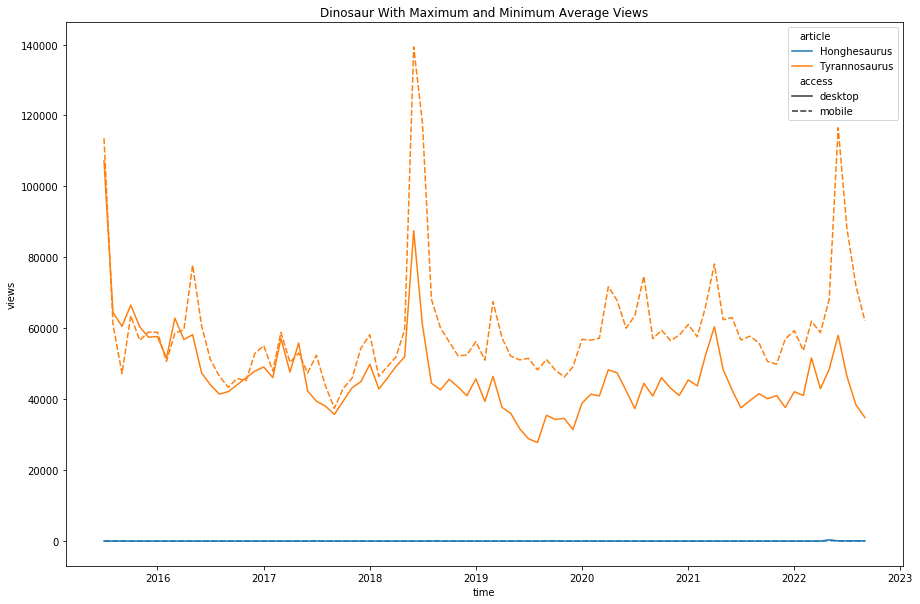

In [459]:
fig, ax = pyplot.subplots(figsize=(15,10))
sns.lineplot(data=df_max_min, x='time', y='views', hue='article', style = 'access').set_title("Dinosaur With Maximum and Minimum Average Views")
plt.savefig('max_min_avg_graph.png')

## Top 10 Peak Page Views

The first step in creating this graph is finding the top 10 articles with the highest peak. To find the peak, I find the max views in a month for each article and then find the indeces of the top 10 articles

In [416]:
desktop_grouped_max = desktop_df.groupby(by='article').max()
mobile_grouped_max = mobile_df.groupby(by='article').max()

desktop_top10 = desktop_grouped_max['views'].nlargest(10).index.to_list()
mobile_top10 = mobile_grouped_max['views'].nlargest(10).index.to_list()

Next, I create a dataframe containing the articles we found above

In [419]:
desktop_sub_peak = desktop_df[desktop_df.article.isin(desktop_top10)]
mobile_sub_peak = mobile_df[mobile_df.article.isin(mobile_top10)]
peaks_df = pd.concat([desktop_sub_peak, mobile_sub_peak]).reset_index()

Finally I create the graph. I seperate the graph by the name of the article indicated by the color and the access type indicated by line type

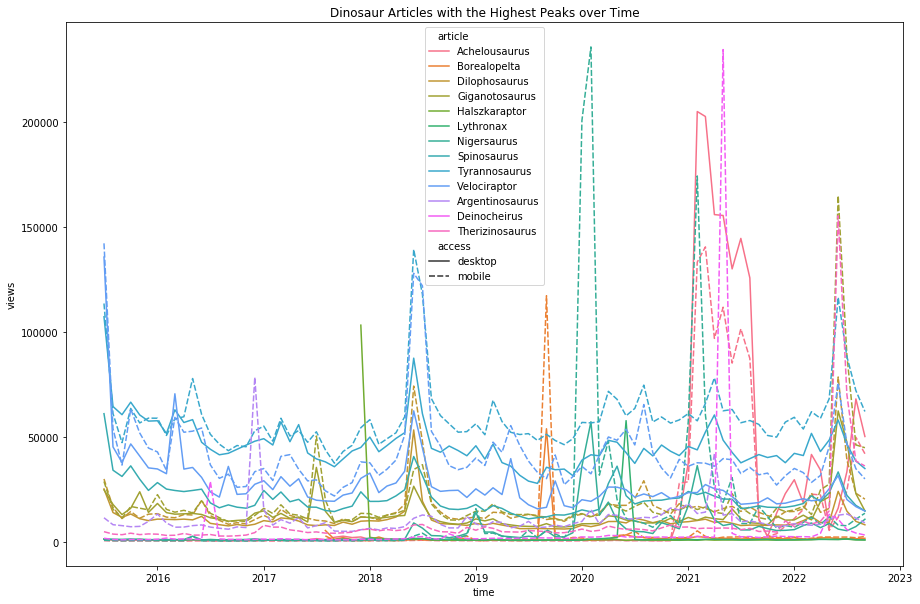

In [460]:
fig, ax = pyplot.subplots(figsize=(15,10))
sns.lineplot(data=peaks_df, x='time', y='views', hue='article', style = 'access').set(title = "Dinosaur Articles with the Highest Peaks over Time")
plt.savefig('top_ten_peaks.png')

## Fewest Months of Data

The first step in creating this graph is finding the articles with the lowest number of months with page views. For this I found the count of the articles which gives us how many months the article had views.

In [450]:
desktop_grouped_count = desktop_df.groupby(by='article').count()
mobile_grouped_count = mobile_df.groupby(by='article').count()

desktop_bot10 = desktop_grouped_count['views'].nsmallest(10).index.to_list()
mobile_bot10 = mobile_grouped_count['views'].nsmallest(10).index.to_list()

Next, I create a dataframe containing the articles we found above

In [451]:
desktop_sub_bot = desktop_df[desktop_df.article.isin(desktop_bot10)]
mobile_sub_bot = mobile_df[mobile_df.article.isin(mobile_bot10)]
fewest_df = pd.concat([desktop_sub_bot, mobile_sub_bot]).reset_index()

Finally I create the graph. I seperate the graph by the name of the article indicated by the color and the access type indicated by line type

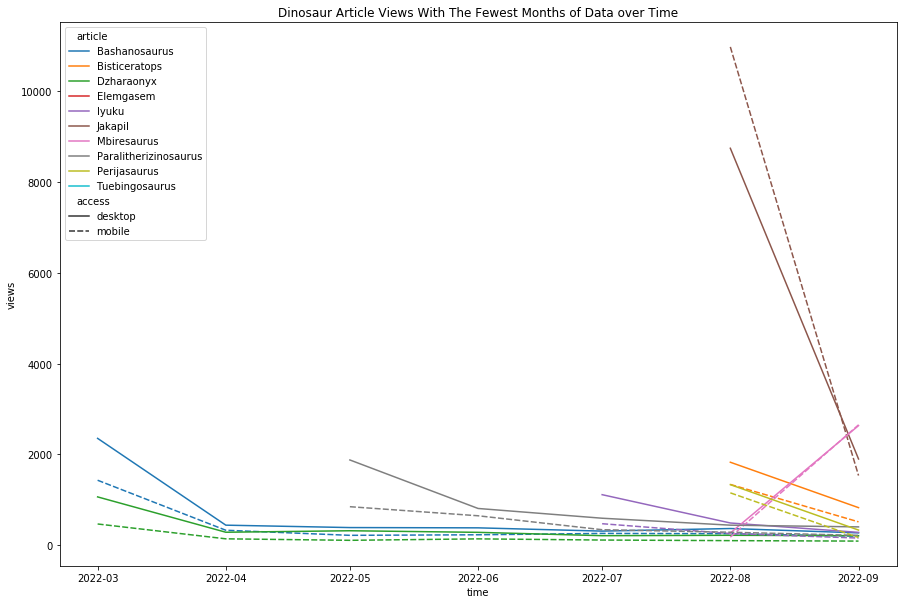

In [462]:
fig, ax = pyplot.subplots(figsize=(15,10))
sns.lineplot(data=fewest_df, x='time', y='views', hue='article', style = 'access').set(title = "Dinosaur Article Views With The Fewest Months of Data over Time")
plt.savefig('fewest_months_data.png')

**Note**: The range of this graph is from March 2022 to September 2022. For lines that start past the begenning of the graph (March 3) that means there was no views before the begenning of the line